Skin Cancer lesion classification using the HAM10000 dataset.

Dataset link: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

The 7 classes of skin Cancer lesions included in this dataset are: akiec, bcc, bkl, df, nv, mel, vasc



In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image
from PIL import Image
import cv2

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get update -qq && apt-get install -y -qq unrar


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
!mkdir -p /content/HAM10000
!unrar x "/content/drive/MyDrive/HAM10000.rar" /content/HAM10000/


Streaming output truncated to the last 5000 lines.
Extracting  /content/HAM10000/archive (2)/HAM10000_images_part_2/ISIC_0029323.jpg      49%  OK 
Extracting  /content/HAM10000/archive (2)/HAM10000_images_part_2/ISIC_0029324.jpg      49%  OK 
Extracting  /content/HAM10000/archive (2)/HAM10000_images_part_2/ISIC_0029325.jpg      49%  OK 
Extracting  /content/HAM10000/archive (2)/HAM10000_images_part_2/ISIC_0029326.jpg      49%  OK 
Extracting  /content/HAM10000/archive (2)/HAM10000_images_part_2/ISIC_0029327.jpg      49%  OK 
Extracting  /content/HAM10000/archive (2)/HAM10000_images_part_2/ISIC_0029328.jpg      49%  OK 
Extracting  /content/HAM10000/archive (2)/HAM10000_images_part_2/ISIC_0029329.jpg      49%  OK 
Extracting  /content/HAM10000/archive (2)/HAM10000_images_part_2/ISIC_0029330.jpg      49%  OK 
Extracting  /content/HAM10000/archive (2)/HAM10000_images_part_2/ISIC_0029331.jpg      49%  OK 
Extr

In [ ]:
!ls -lah /content/HAM10000
!find /content/HAM10000 -maxdepth 2 -type d -print



total 12K
drwxr-xr-x 3 root root 4.0K Jan  8 19:09  .
drwxr-xr-x 1 root root 4.0K Jan  8 19:09  ..
drwxr-xr-x 4 root root 4.0K Sep 18 12:03 'archive (2)'
/content/HAM10000
/content/HAM10000/archive (2)
/content/HAM10000/archive (2)/HAM10000_images_part_1
/content/HAM10000/archive (2)/HAM10000_images_part_2


In [ ]:
from pathlib import Path

DATA_DIR = Path("/content/HAM10000/archive (2)")  # adjust if needed
p1 = DATA_DIR / "HAM10000_images_part_1"
p2 = DATA_DIR / "HAM10000_images_part_2"

n1 = len(list(p1.glob("*.jpg")))
n2 = len(list(p2.glob("*.jpg")))
print("part_1 jpgs:", n1, " | part_2 jpgs:", n2, " | total:", n1+n2)  # expect 10015


part_1 jpgs: 5000  | part_2 jpgs: 5015  | total: 10015


In [ ]:
import pandas as pd

metadata_path = os.path.join(DATA_DIR, "HAM10000_metadata.csv")
metadata = pd.read_csv(metadata_path)
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
metadata.shape

(10015, 7)

Load the images paths:
Create 2 paths from drive. The images are separeted in these paths, so if they do not exist in path 1 they probably exist in path 2. Scanning all the rows using the "dx" and the "image_id" columns we can add the image path in a separete column in the dataframe.

In [ ]:
import os, glob
import pandas as pd

# 0) Confirm your metadata DF exists
print("metadata shape:", metadata.shape)

# 1) Set correct base dirs (NO class subfolders)
DATA_DIR  = "/content/HAM10000/archive (2)"
BASE1_DIR = os.path.join(DATA_DIR, "HAM10000_images_part_1")
BASE2_DIR = os.path.join(DATA_DIR, "HAM10000_images_part_2")

print("BASE1 exists?", os.path.isdir(BASE1_DIR), "->", BASE1_DIR)
print("BASE2 exists?", os.path.isdir(BASE2_DIR), "->", BASE2_DIR)

# 2) Index all image files from both parts
jpgs = glob.glob(os.path.join(BASE1_DIR, "*.jpg")) + glob.glob(os.path.join(BASE2_DIR, "*.jpg"))
print("Total jpgs found:", len(jpgs))
assert len(jpgs) > 0, "No .jpg files found. Check that your dataset is extracted under /content/HAM10000/archive (2)."

# 3) Build id -> fullpath dict (e.g., 'ISIC_0024306' -> '/content/.../ISIC_0024306.jpg')
id2path = {os.path.splitext(os.path.basename(p))[0]: p for p in jpgs}
print("Unique ids indexed:", len(id2path))

# 4) Map into the DF (length will ALWAYS match)
metadata["image_path"] = metadata["image_id"].map(id2path.get)

# 5) Report any misses
missing = metadata["image_path"].isna().sum()
print("Missing paths:", missing)
if missing:
    print("Example missing IDs:", metadata.loc[metadata["image_path"].isna(), "image_id"].head().tolist())

# 6) Peek
metadata.head()

metadata shape: (10015, 7)
BASE1 exists? True -> /content/HAM10000/archive (2)/HAM10000_images_part_1
BASE2 exists? True -> /content/HAM10000/archive (2)/HAM10000_images_part_2
Total jpgs found: 10015
Unique ids indexed: 10015
Missing paths: 0


lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                          image_path  
0  /content/HAM10000/archive (2)/HAM10000_images_...  
1  /content/HAM10000/archive (2)/HAM10000_images_...  
2  /content/HAM10000/archive (2)/HAM10000_images_...  
3  /content/HAM10000/archive (2)/HAM10000_images_...  
4  /content/HAM10000/archive (2)/HAM10000_images_...

Check the distribution of the class


In [ ]:
import os

DATA_DIR = "/content/HAM10000/archive (2)"
print("✅ DATA_DIR:", DATA_DIR)
print(os.listdir(DATA_DIR))
print("metadata shape:", metadata.shape)             # should be (10015, ?)
print("unique image_id:", metadata["image_id"].nunique())  # 10015
print("dx distribution:\n", metadata["dx"].value_counts().sort_index())

✅ DATA_DIR: /content/HAM10000/archive (2)
['HAM10000_images_part_1', 'HAM10000_metadata.csv', 'HAM10000_images_part_2']
metadata shape: (10015, 8)
unique image_id: 10015
dx distribution:
 dx
akiec     327
bcc       514
bkl      1099
df        115
mel      1113
nv       6705
vasc      142
Name: count, dtype: int64


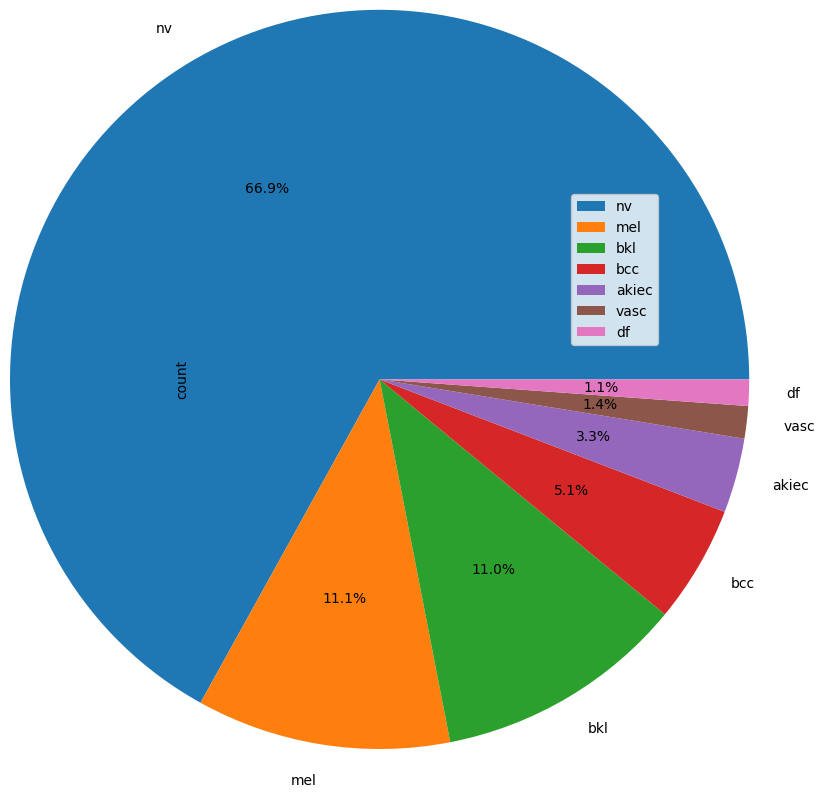

In [ ]:
count = metadata['dx'].value_counts()
ax = count.plot(kind="pie", autopct='%1.1f%%', legend=True,radius=2.5)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

/tmp/ipython-input-1737115017.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


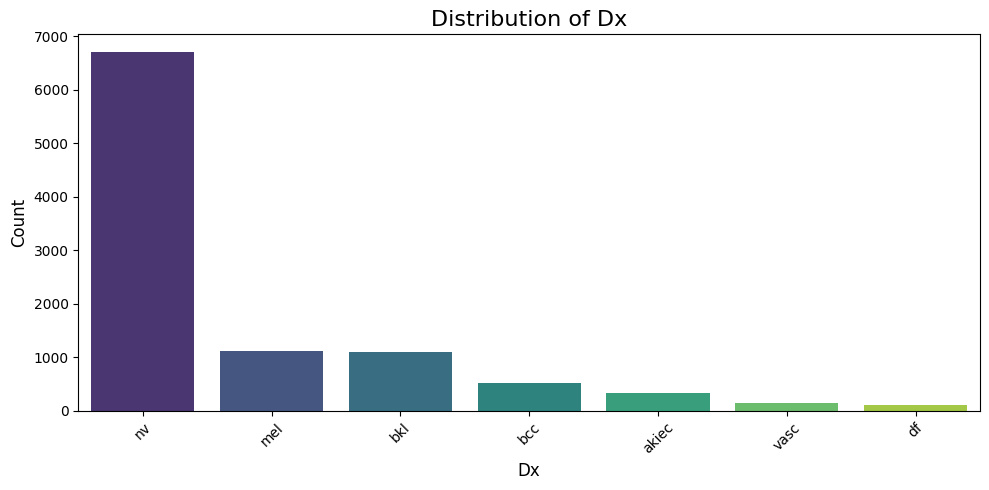

/tmp/ipython-input-1737115017.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


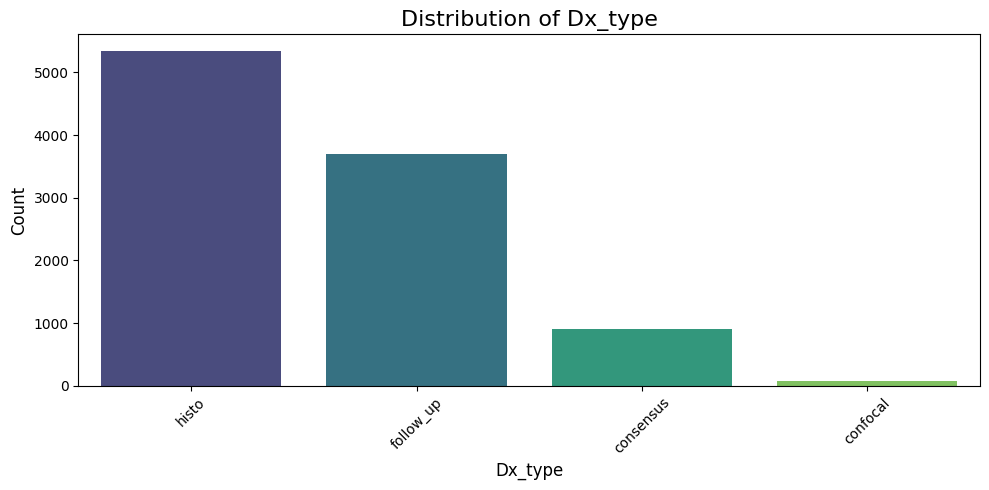

/tmp/ipython-input-1737115017.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


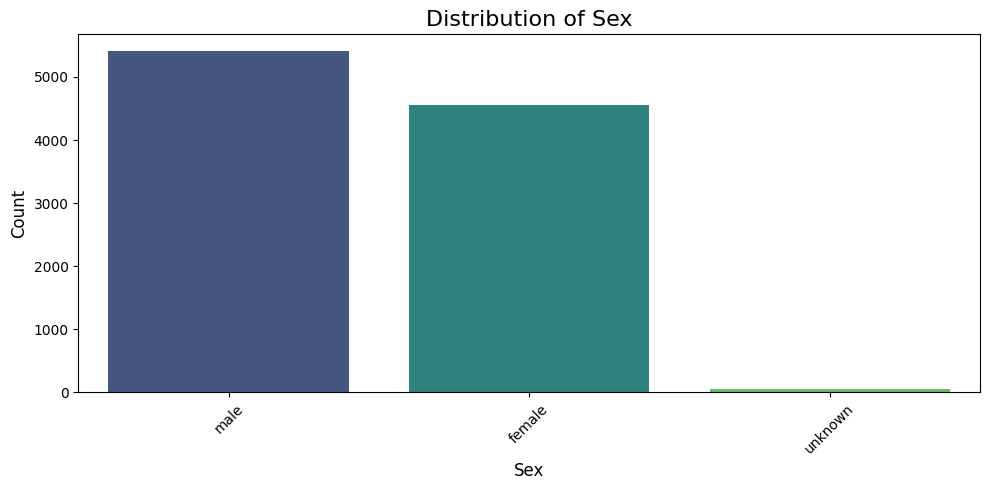

/tmp/ipython-input-1737115017.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


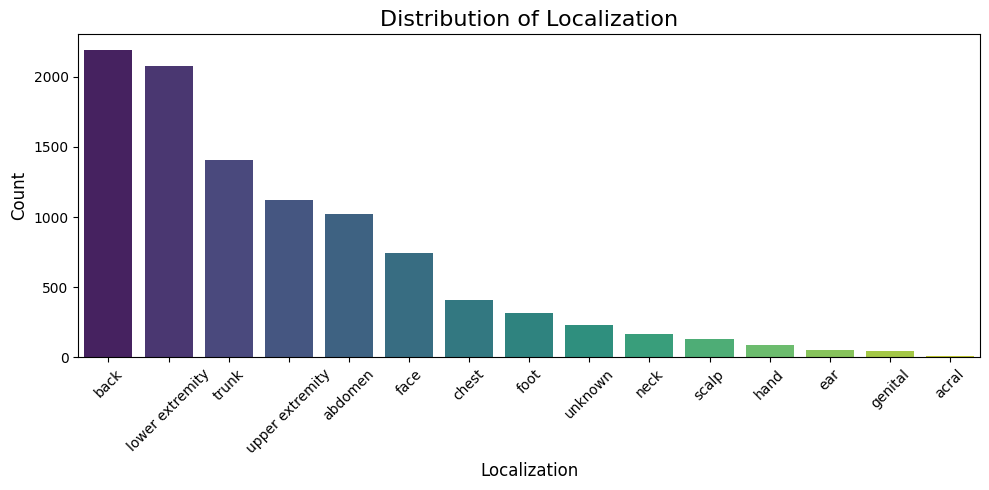

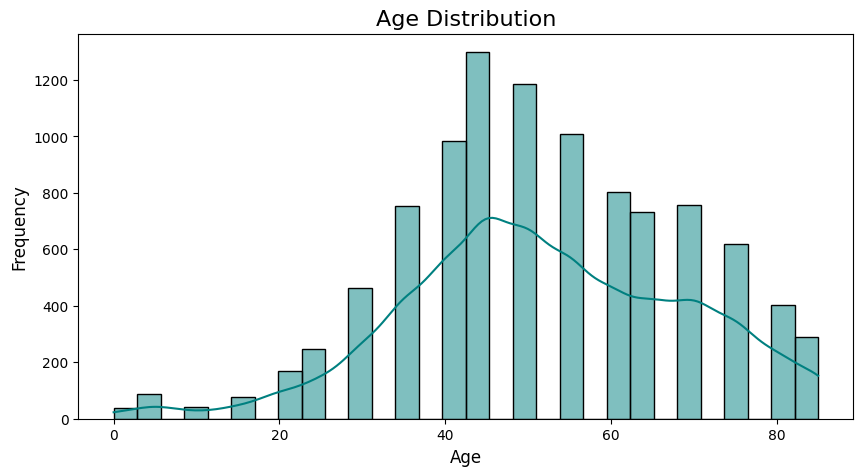

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_exp = ['dx','dx_type', 'sex', 'localization']

for column in columns_exp:
    plt.figure(figsize=(10,5))

    sns.countplot(
        data=metadata,
        x=column,
        order=metadata[column].value_counts().index,
        palette="viridis"
    )

    plt.title(f"Distribution of {column.capitalize()}", fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# AGE as histogram (correct method)
plt.figure(figsize=(10,5))
sns.histplot(metadata["age"].dropna(), bins=30, kde=True, color="teal")
plt.title("Age Distribution", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


Clean the metadata:
Missing data: Fill the missing values with the mean of their category, since the category is a float number.

In [ ]:
def check_for_missing_data(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    return summary

In [ ]:
check_for_missing_data(metadata)

Name   dtypes  Missing
0     lesion_id   object        0
1      image_id   object        0
2            dx   object        0
3       dx_type   object        0
4           age  float64       57
5           sex   object        0
6  localization   object        0
7    image_path   object        0

Remove the duplicates if there are any

In [ ]:
assert metadata.shape[0] == 10015
# QC: true duplicates of the same image (rare; caused by prior processing)
before = len(metadata)
metadata = metadata.drop_duplicates(subset=["image_id"], keep="first")
print("dropped dup image_id rows:", before - len(metadata))


dropped dup image_id rows: 0


In [ ]:
metadata.shape

(10015, 8)

In [ ]:
metadata.loc[metadata['sex']=='unknown'].shape

(57, 8)

In [ ]:
metadata.loc[metadata['localization']=='unknown'].shape

(234, 8)

/tmp/ipython-input-3830741751.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=metadata, x="dx", y="age", palette="Set3")


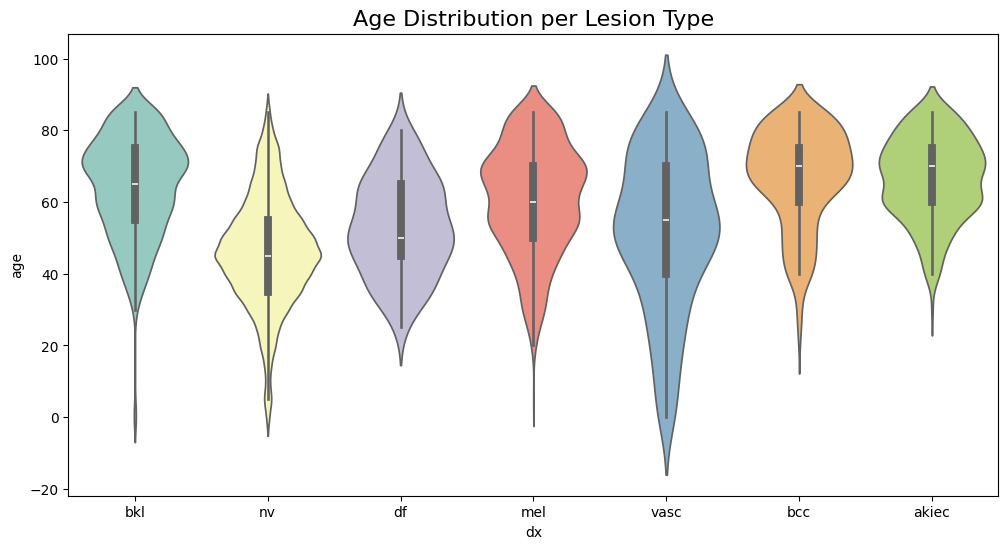

In [ ]:
plt.figure(figsize=(12,6))
sns.violinplot(data=metadata, x="dx", y="age", palette="Set3")
plt.title("Age Distribution per Lesion Type", fontsize=16)
plt.show()

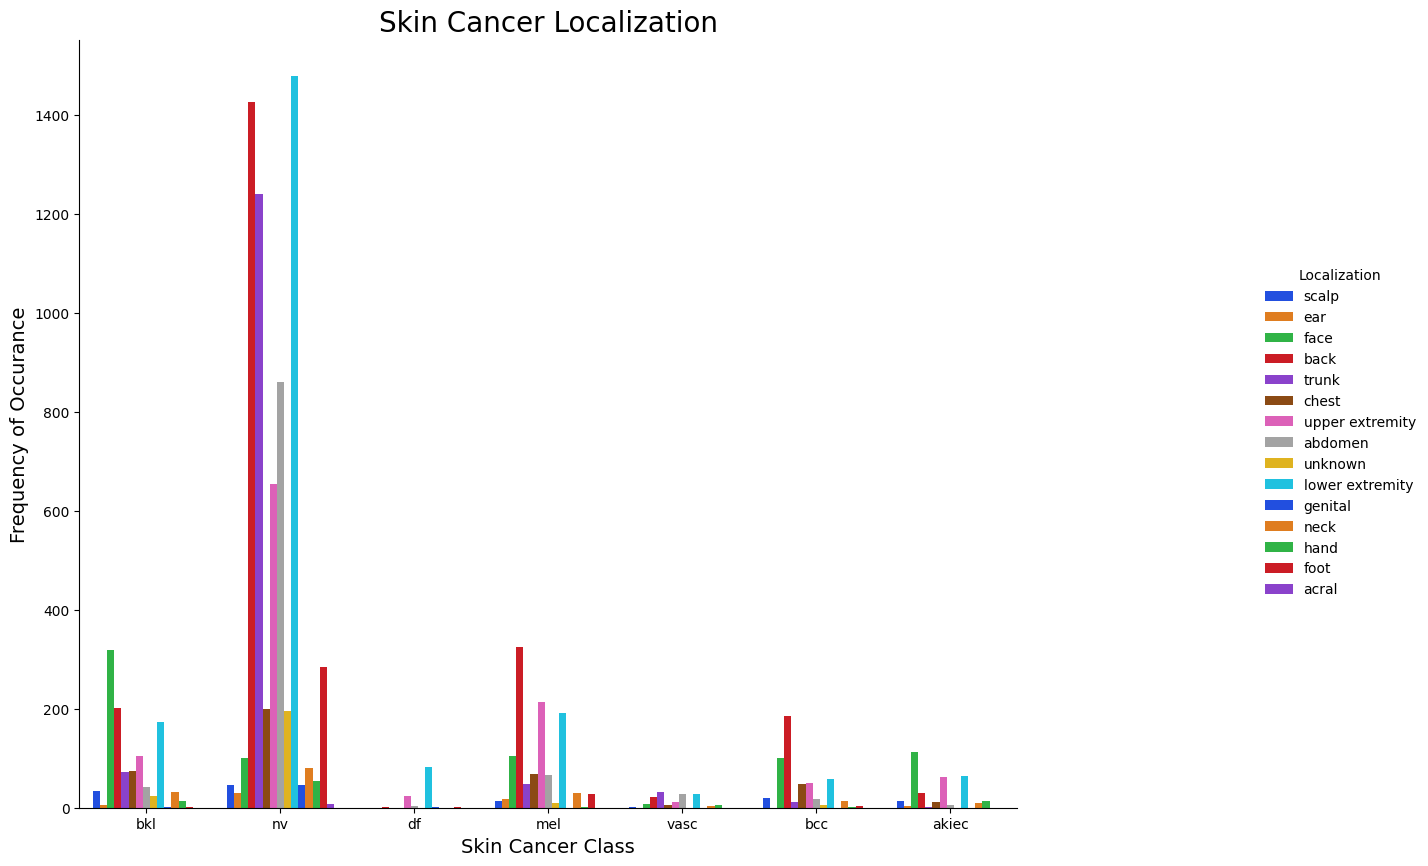

In [ ]:
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')

Plot images from each class and their color distributions


--- Showcasing examples for class: bkl ---



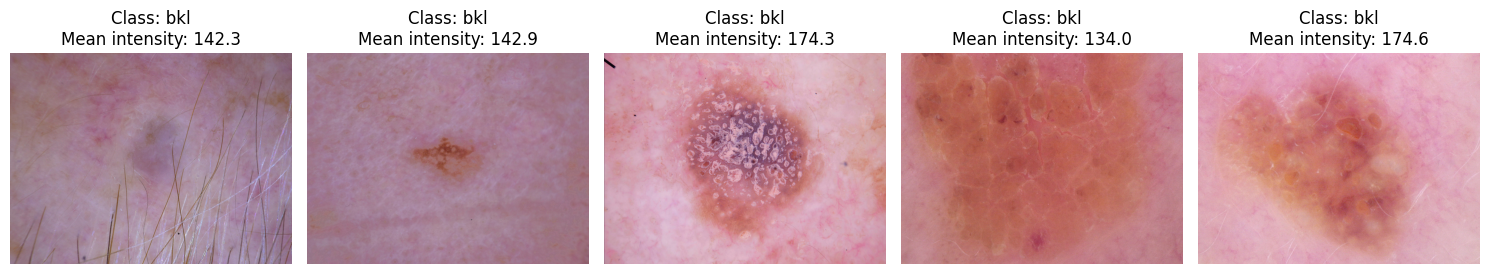

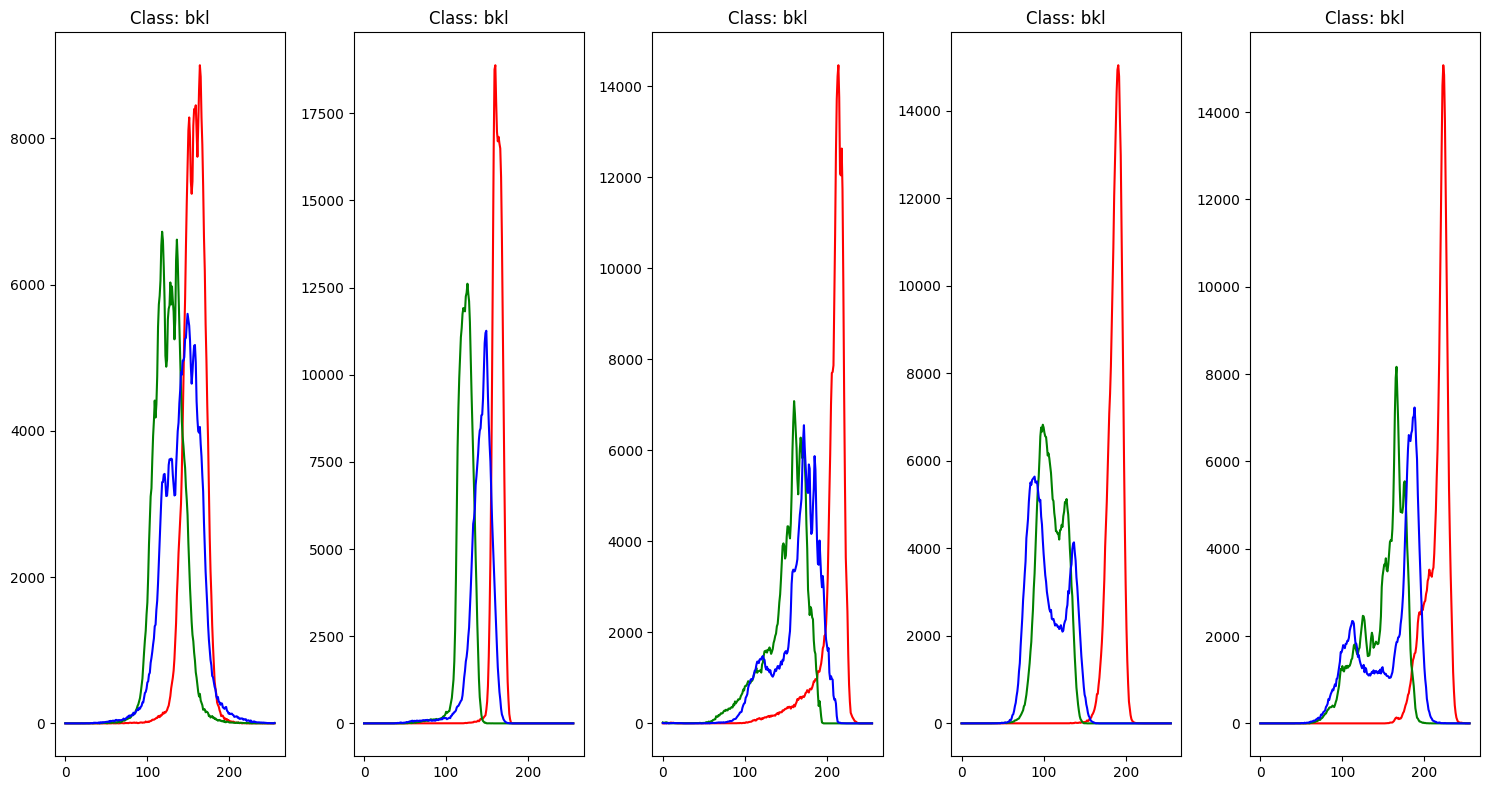


--- Showcasing examples for class: nv ---



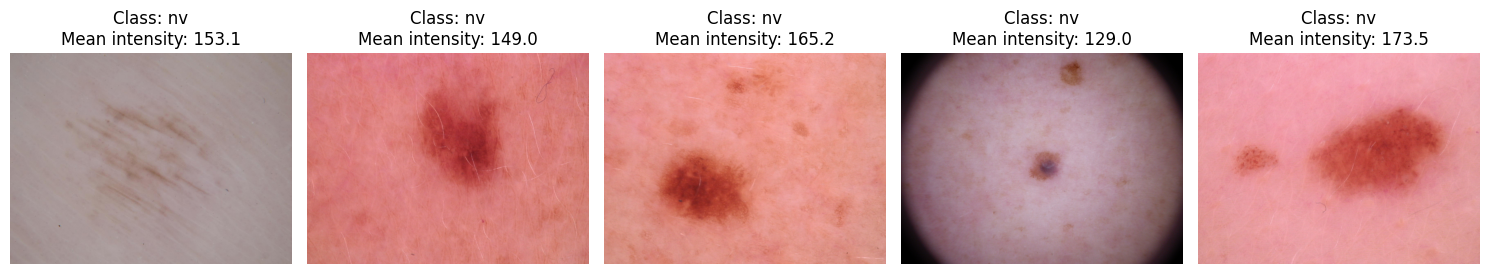

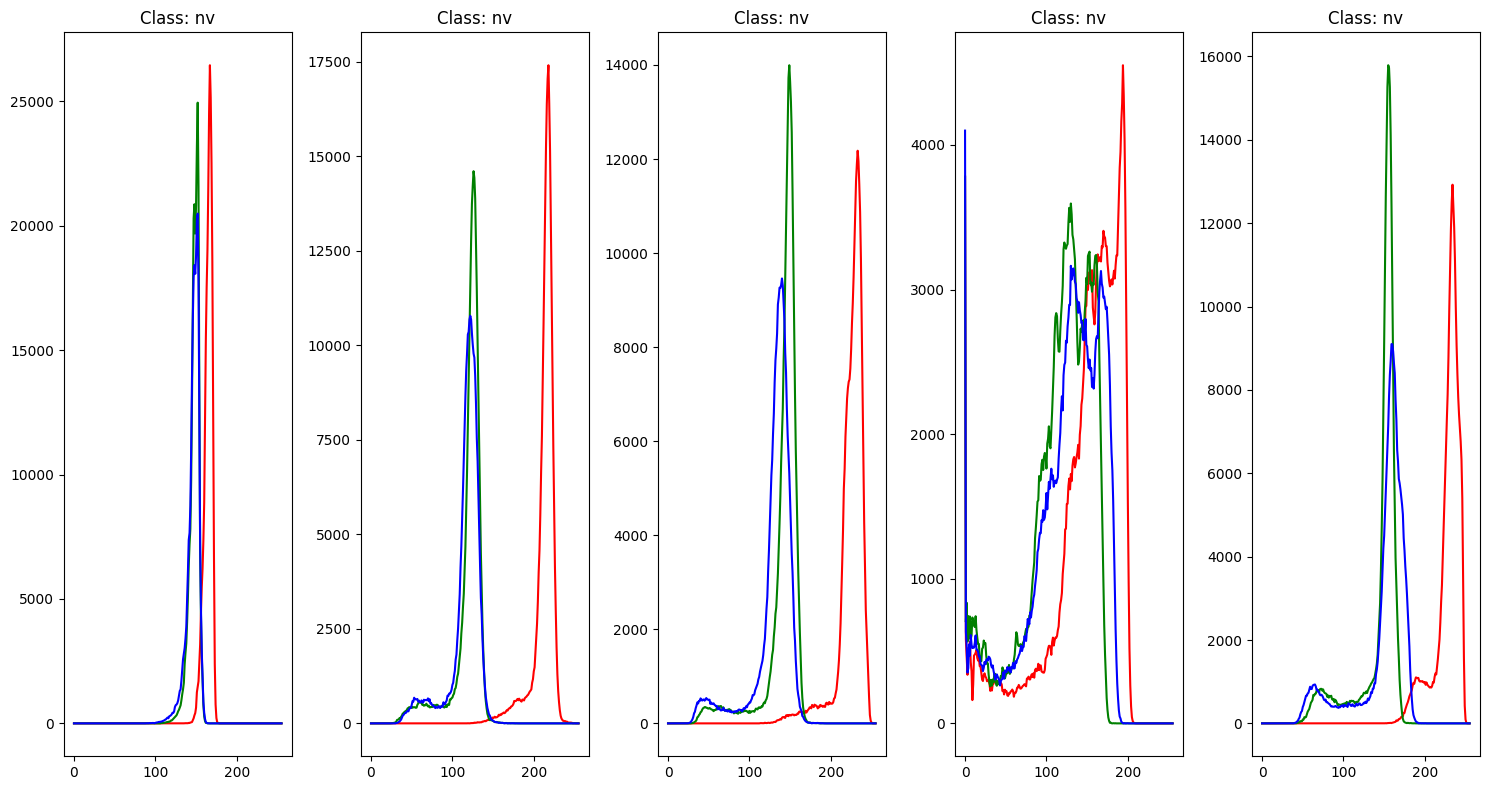


--- Showcasing examples for class: df ---



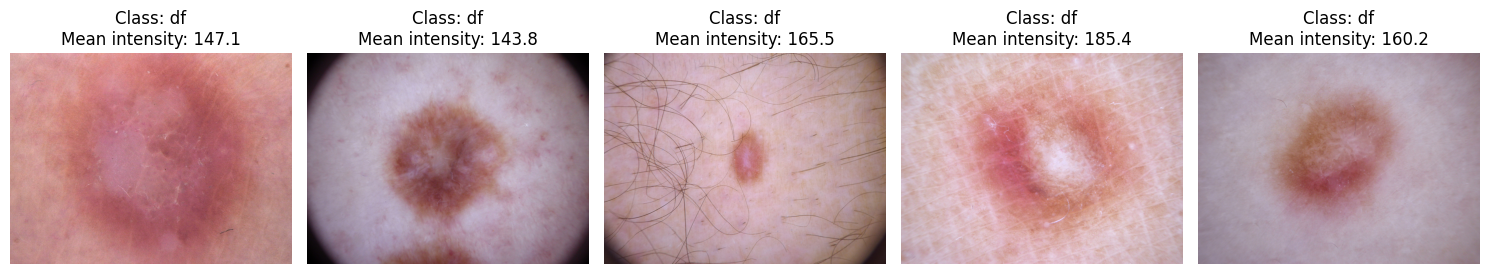

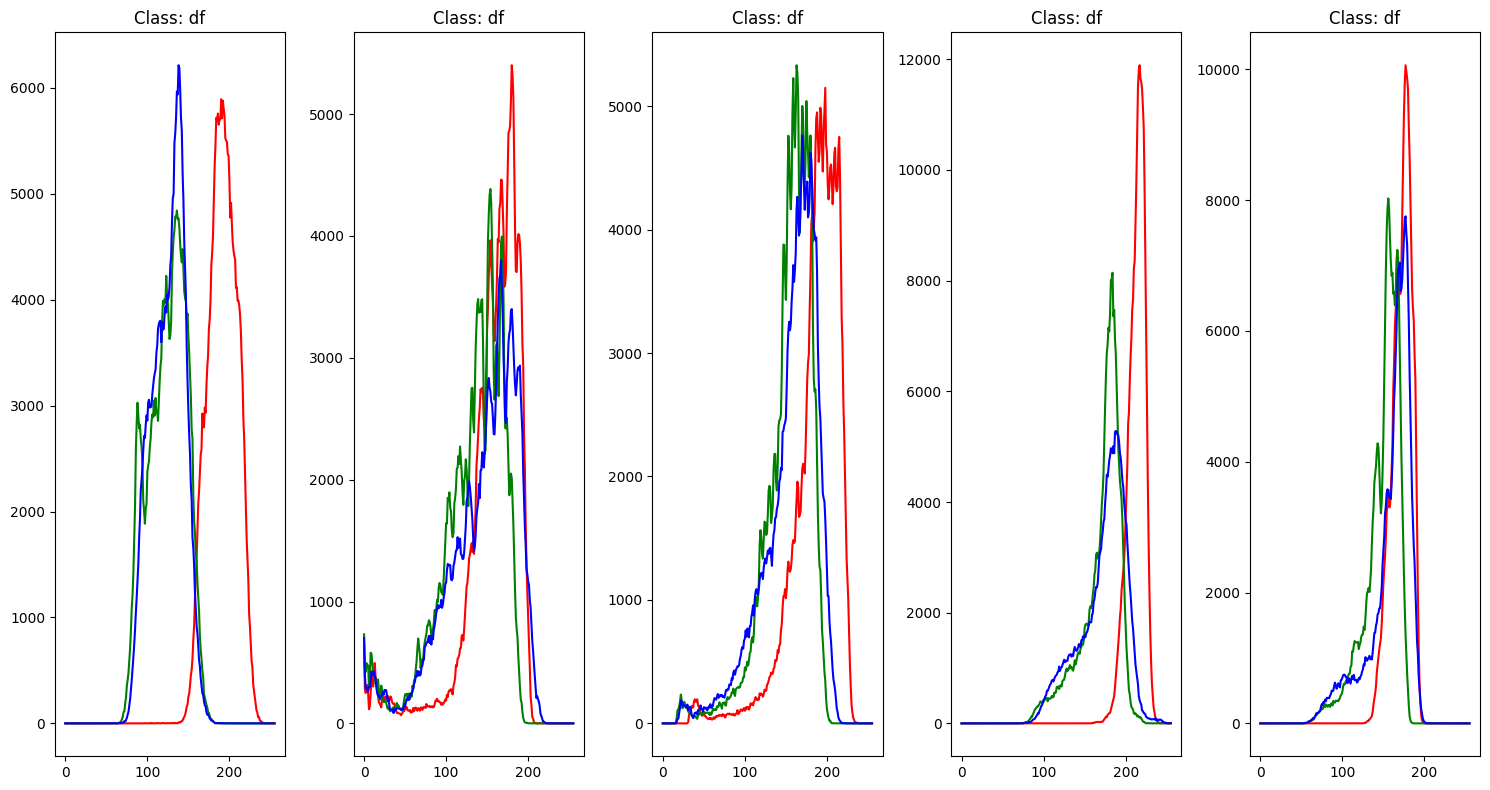


--- Showcasing examples for class: mel ---



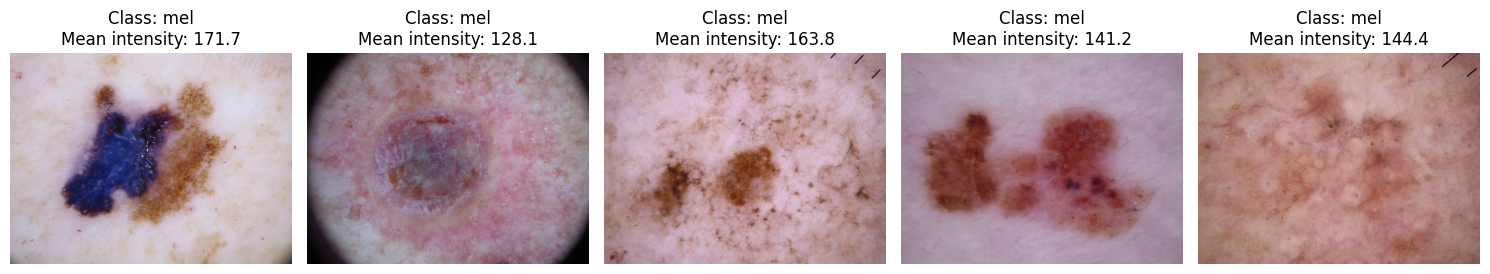

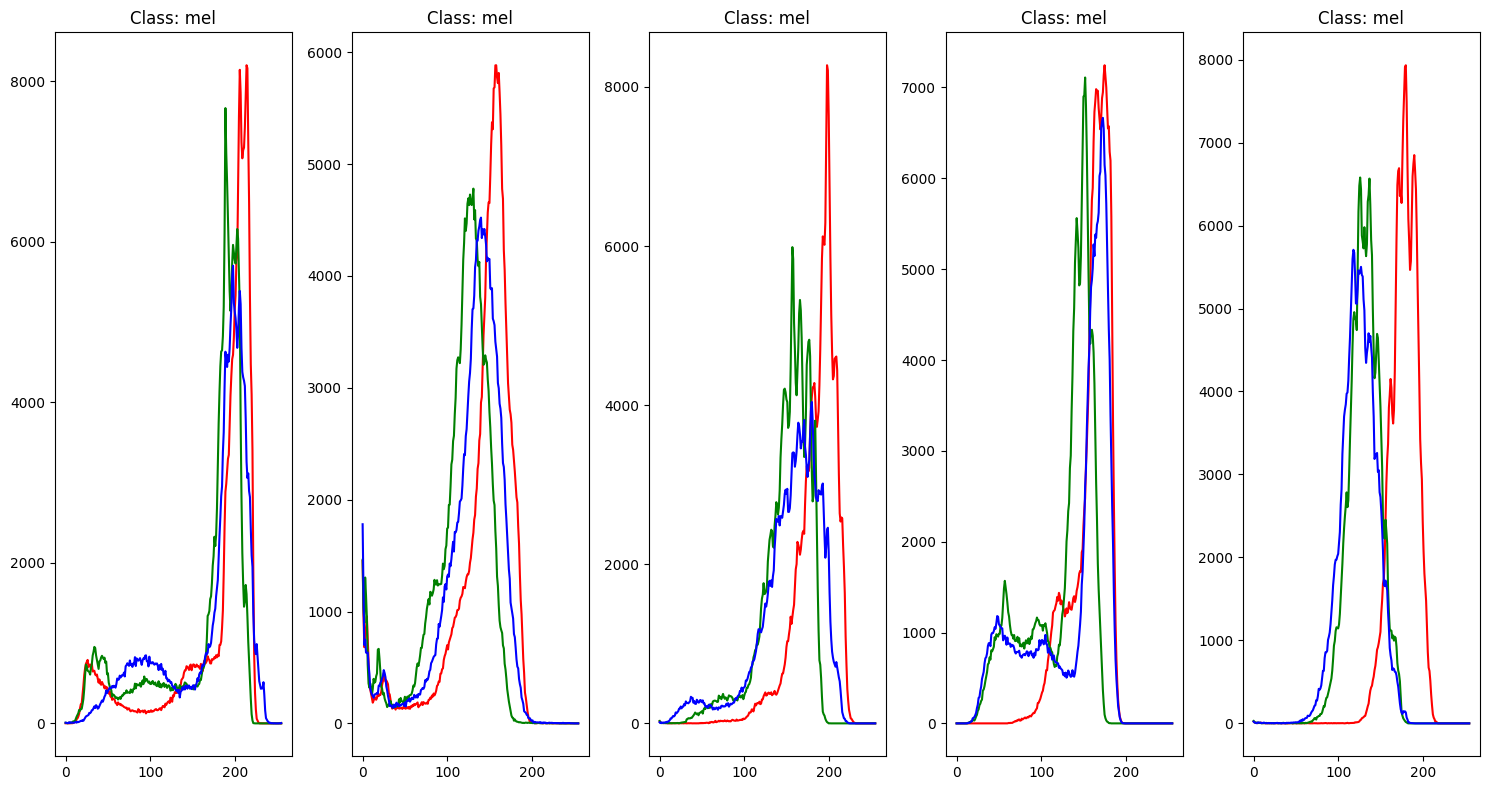


--- Showcasing examples for class: vasc ---



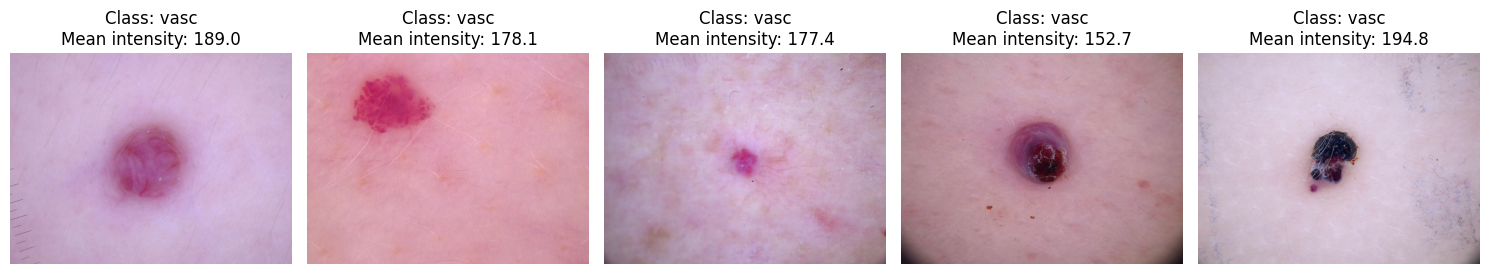

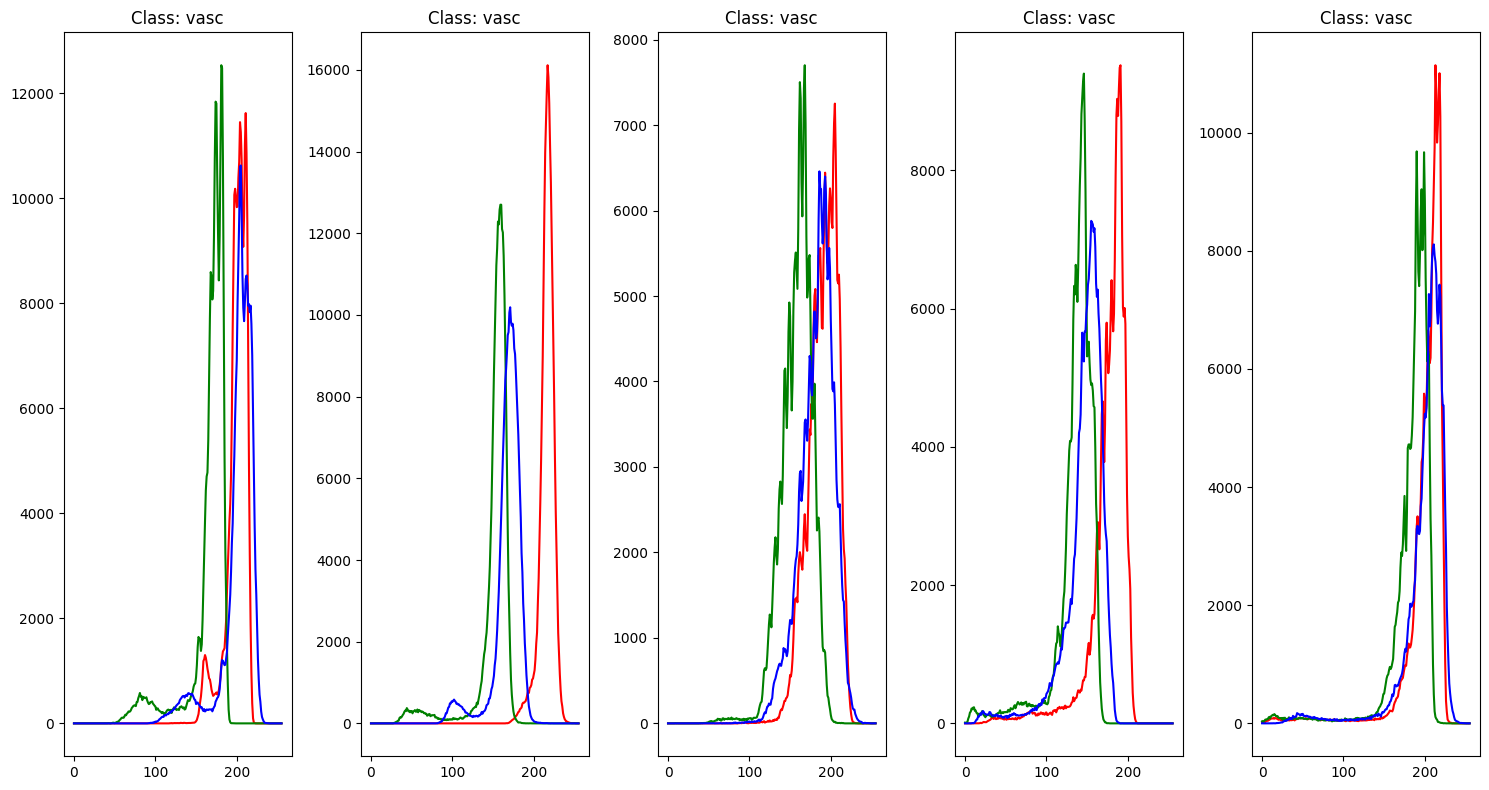


--- Showcasing examples for class: bcc ---



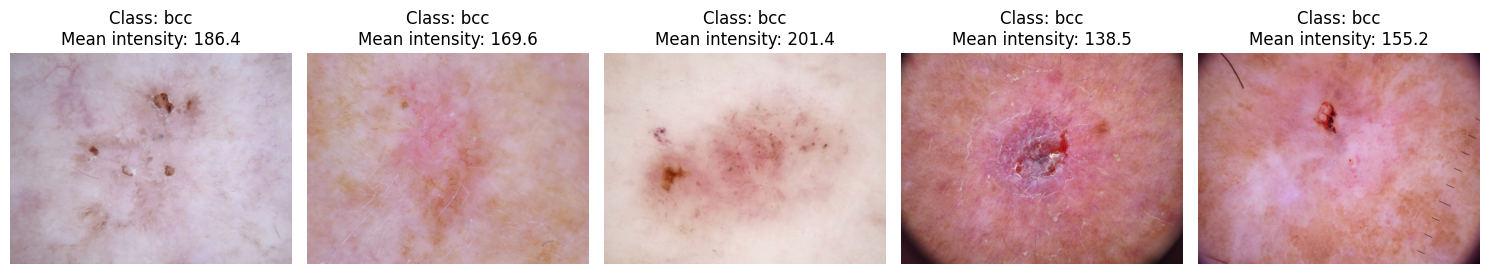

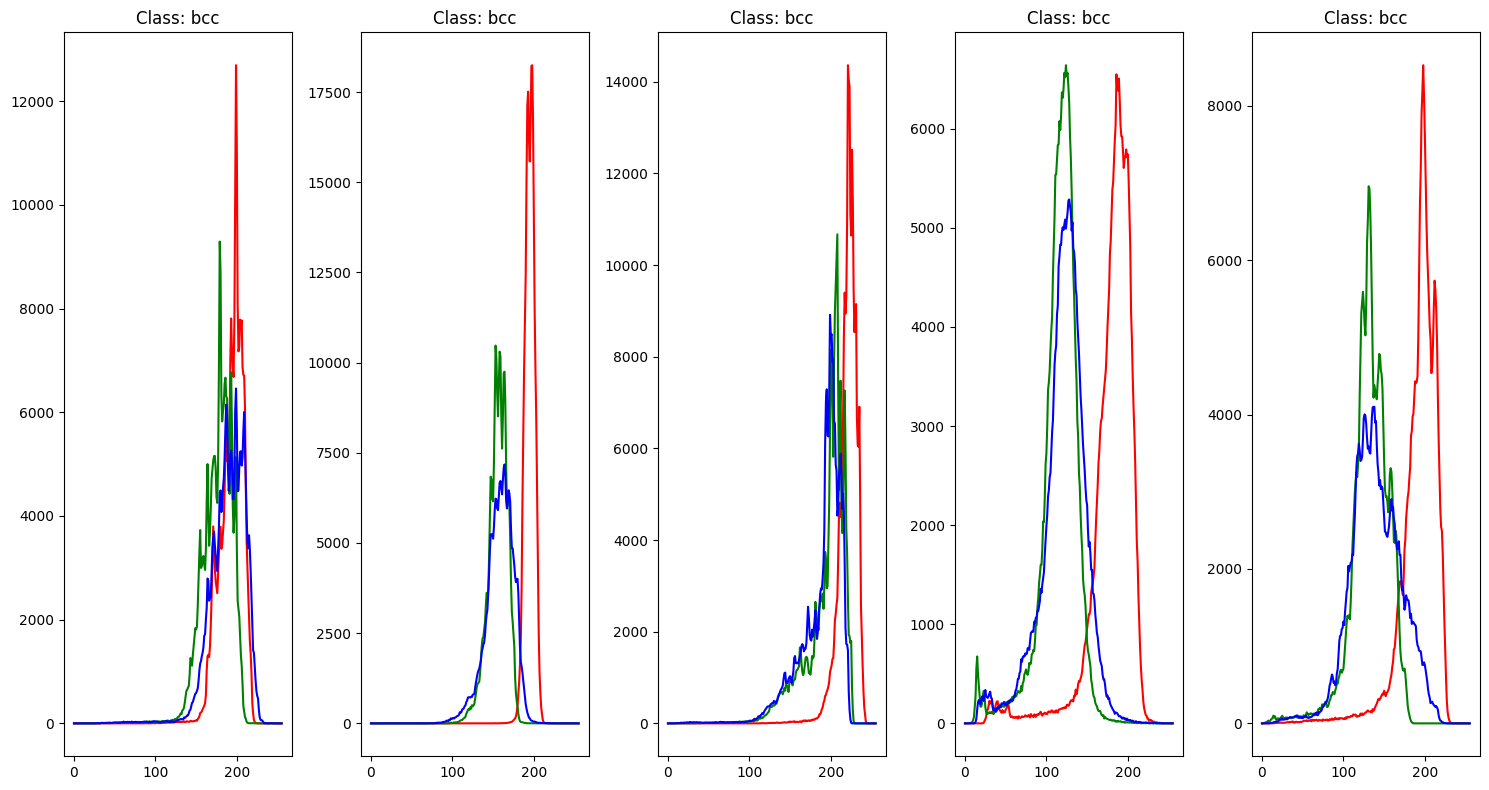


--- Showcasing examples for class: akiec ---



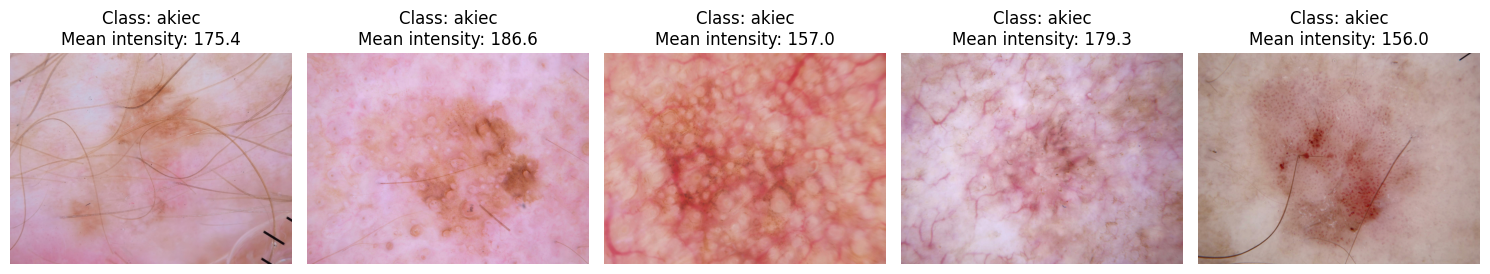

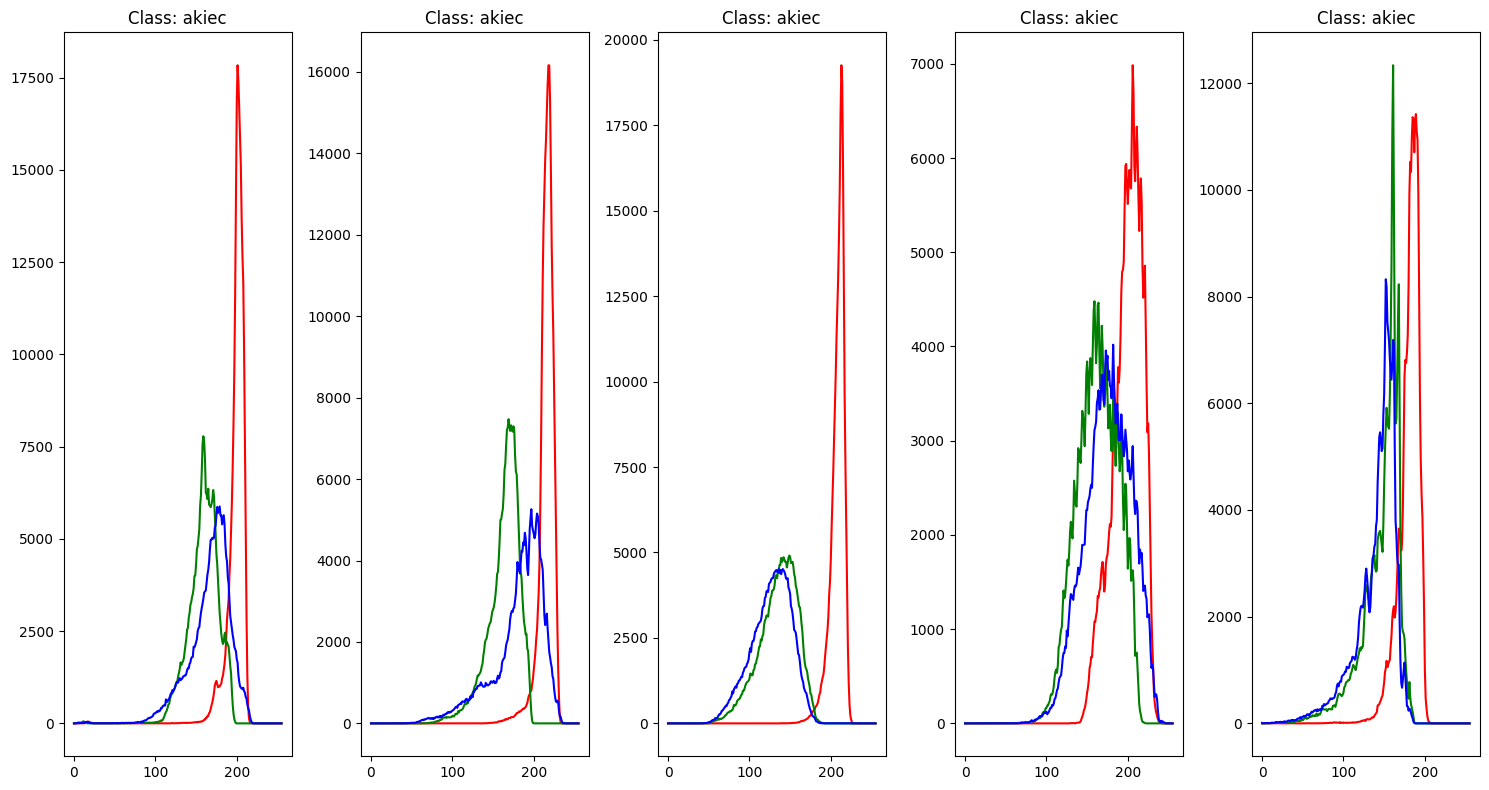

In [ ]:
def pltImg(images, labels, row_num, col_num):
    fig, axes = plt.subplots(row_num, col_num, figsize=(15, 8))
    axes = axes.ravel()  # Flatten axes array

    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Class: {labels[i]}\nMean intensity: {np.mean(image):.1f}")

    plt.tight_layout()
    plt.show()


def pltHist(images, labels, row_num, col_num):
    fig, axes = plt.subplots(row_num, col_num, figsize=(15, 8))
    axes = axes.ravel()  # Flatten axes array
    colors = ["red", "green", "blue"]

    for i, image in enumerate(images):
        image_array = np.array(image)

        # Plotting all channels with colors
        for channel in range(3):
            hist, bin_edges = np.histogram(image_array[:, :, channel], bins=256, range=(0, 256))
            axes[i].plot(bin_edges[:-1], hist, color=colors[channel])

        axes[i].set_title(f"Class: {labels[i]}")

    plt.tight_layout()
    plt.show()
def randImg(df, label, seed, sample_size):
    # Filter dataframe for specific label/class
    df_class = df[df['dx'] == label]

    # Randomly sample images from this class
    random.seed(seed)
    sample_df = df_class.sample(n=sample_size)

    images = []
    labels = []
    for index, row in sample_df.iterrows():
        image_path = row['image_path']
        if os.path.exists(image_path):
            image = Image.open(image_path).convert("RGB")
            images.append(image)
            labels.append(label)
        else:
            print(f"Image not found: {image_path}")

    return images, labels


class_labels = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

for class_label in class_labels:
    print(f"\n--- Showcasing examples for class: {class_label} ---\n")
    images, labels = randImg(df=metadata, label=class_label, seed=42, sample_size=5)

    # For displaying images
    pltImg(images, labels, 1, 5)
    # pltImgEq(images, labels, 1, 5)
    # For displaying histograms
    pltHist(images, labels, 1, 5)

In [ ]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/content/HAM10000/archive (2)")
p1 = DATA_DIR / "HAM10000_images_part_1"
p2 = DATA_DIR / "HAM10000_images_part_2"

# Build a fresh id -> path dictionary
id2path = {}
for folder in [p1, p2]:
    for f in folder.glob("*.jpg"):
        id2path[f.stem] = str(f.resolve())

# Attach/refresh image_path on the *metadata* DF
metadata["image_path"] = metadata["image_id"].map(id2path)

missing = metadata["image_path"].isna().sum()
print("Rows missing image files in metadata:", missing)


Rows missing image files in metadata: 0


In [ ]:
MAL = {'mel','bcc','akiec'}           # 1 = malignant
BEN = {'nv','bkl','df','vasc'}        # 0 = benign

df = metadata[metadata["dx"].isin(MAL | BEN)].copy()
df["label"] = df["dx"].apply(lambda x: 1 if x in MAL else 0)

# sanity
print("Columns in df:", list(df.columns)[:10])
assert "image_path" in df.columns


Columns in df: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'image_path', 'label']


In [ ]:
df["label"].value_counts()



label
0    8061
1    1954
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.15,
    stratify=train_df["label"],
    random_state=42
)
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))


Train size: 7235
Validation size: 1277
Test size: 1503


In [ ]:
def show_percentages(df, name):
    percent = df["label"].value_counts(normalize=True) * 100
    print(f"\n{name} (%)")
    print(percent)

show_percentages(train_df, "Train")
show_percentages(val_df, "Validation")
show_percentages(test_df, "Test")



Train (%)
label
0    80.48376
1    19.51624
Name: proportion, dtype: float64

Validation (%)
label
0    80.501175
1    19.498825
Name: proportion, dtype: float64

Test (%)
label
0    80.505655
1    19.494345
Name: proportion, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split

# binary label
malignant = ["mel", "bcc", "akiec"]
metadata["label"] = metadata["dx"].isin(malignant).astype(int)

train_df, temp_df = train_test_split(
    metadata,
    test_size=0.30,
    stratify=metadata["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

# SAVE WITH FULL PATHS
train_df[["image_path", "label"]].to_csv("/content/drive/MyDrive/train.csv", index=False)
val_df[["image_path", "label"]].to_csv("/content/drive/MyDrive/val.csv", index=False)
test_df[["image_path", "label"]].to_csv("/content/drive/MyDrive/test.csv", index=False)

print("✅ CSVs saved with correct absolute paths")



✅ CSVs saved with correct absolute paths


In [ ]:
ls

drive/  HAM10000/  sample_data/
